#Naive Bayes

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [ ]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [ ]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [ ]:
df.head()  # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

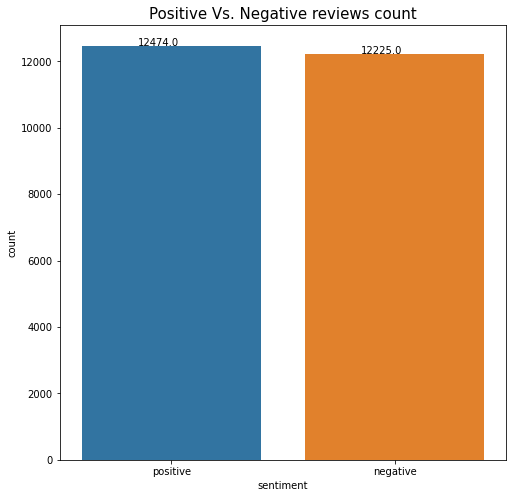

In [ ]:
plt.figure(figsize = [8,8])
ax = sns.countplot(df.sentiment)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

It can be seen that there is a very slight imbalance in the two classes present.

## Upsampling the minority class

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [ ]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment'] == 'positive']
df_minority = df[df['sentiment'] == 'negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority , negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [ ]:
df_upsampled

,review,sentiment
15633,That is the promise of the trailer I saw and b...,positive
20757,"As I was watching this movie I was thinking,OK...",negative
14270,"I posted on IMDb on this series recently, givi...",positive
19958,"I caught this movie about 8 years ago, and hav...",positive
1168,Ayone who whines about how this movie was crap...,positive
...,...,...
19237,Apparently this was an award winner. Apparentl...,negative
2526,I was impressed by the beautiful photography i...,positive
11914,I took this out arbitrarily from the library t...,positive
14673,A girl is showering unknowing that a serial ra...,negative


In [ ]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 
# print the shape of data set with the help of shape function having "negative" as class label
print('Shape of dataframe having negative as class label is' , df_upsampled[df_upsampled['sentiment'] == 'negative'].shape)

Shape of dataframe having negative as class label is (12474, 2)


### Expected Output : 
(12474, 2)

In [ ]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
print('Shape of dataframe having positive as class label is' , df_upsampled[df_upsampled['sentiment'] == 'positive'].shape)

Shape of dataframe having positive as class label is (12474, 2)


### Expected Output : 
(12474, 2)

In [ ]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'] , negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train['sentiment'] , positive_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'] , negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test['sentiment'] , positive_data_points_test['sentiment']])


In [ ]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [ ]:
y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Pre-process the reviews

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [ ]:
# TASK CELL

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    review = review.lower() #Converting the review to lowercase
    review = re.sub(r'[^\w\s]', '', review) #Removing the punctuations in the reviews using regex
    review = re.sub(r'https?://\S+|www\.\S+', '', review) #Removing the links in the review using regex
    review_cleaned = word_tokenize(review) #This function is to tokenize the review
    review_cleaned = [r for r in review_cleaned if r not in stopwords.words("english")] #Removing the stop words from the list of tokens
    #ps = PorterStemmer()
    wn = nltk.WordNetLemmatizer()
    review_cleaned = [wn.lemmatize(x) for x in review_cleaned] #This function is to lemmatize the review
    review_cleaned = ' '.join(word for word in review_cleaned)


    return review_cleaned



In [ ]:
clean_review(X_train[1032])

'although fan heather thomas old bikini poster around somewhere honestly say movie ever seen cyclone would never able guess made far show businessbr br directed fred olen ray good omen seeing buzzard circle head desert tale woman thomas must protect hightech motorcycle unscrupulous type b movie get fred olens case b minusbr br cast tell something every movie combine thomas actor calibre beswick hall comb donahue tamblyn landau youre lucky movie even though seem fun shouldnt fun passed audience vote yes seems voted nobr br course ever wanted see heather deliver uppercut another woman use f word get hooked battery cable youve probably looking one ill content old fall guy rerunsbr br one star given hope another cyclone hit town heather run shelter know'

## Implement a find_occurrence function

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [ ]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    pair = (word, label)
    if pair in frequency:
        n = frequency[pair]
    else:
        n = 0

    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [ ]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [ ]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [ ]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60\'s movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [ ]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

promise trailer saw rented hitch exactly serious film viewer shall expect much title surprisingly enough smith mendes james valletta managed reach theatrical performance could metaphorically summarised rap dancefloor routine end film character formed effective combo may prompt good laugh sunday afternoon dvd providing date exquisite frenchswedishdirectorsofthe60s movie fanbr br p technique score true especially cocktail girl routine


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Implementing review counter function

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [ ]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
          if (word, label) in output_occurrence:
                   output_occurrence[(word,label)] += 1
          else:
                output_occurrence[(word,label)] = 1

    return output_occurrence
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [ ]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('bored', 1): 2,
 ('complete', 1): 1,
 ('enjoyed', 0): 1,
 ('fantastic', 0): 1,
 ('fullest', 0): 1,
 ('got', 1): 1,
 ('money', 1): 1,
 ('movie', 0): 2,
 ('moview', 1): 1,
 ('throught', 1): 1,
 ('time', 1): 1,
 ('waste', 1): 1,
 ('watch', 1): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [ ]:
# Build the freqs dictionary for later uses 

freqs = review_counter({}, X_train, y_train)

In [ ]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

##Training the Naive Bayes Model

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [ ]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = np.unique(np.array(list(freqs.keys()))[:, 0])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 0:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = train_y.shape[0]
    # Calculate D_pos, the number of positive documents 
    pos_num_docs = sum(train_y == 1)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = sum(train_y == 0)

    # Calculate logprior
    prob_positive = pos_num_docs/num_doc
    prob_negative = neg_num_docs/num_doc
    logprior = np.log(prob_positive) - np.log(prob_negative)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(num_pos+V)
        p_w_neg = (freq_neg+1)/(num_neg+V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg)


    return logprior, loglikelihood

In [ ]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
92204


### Expected Output 

0.0 <br>
91425

In [ ]:
loglikelihood = pd.DataFrame(loglikelihood.items())
loglikelihood.to_csv('loglikelihood_values.csv', index = False, header=True) #To create a local file for question 8

In [ ]:
loglikelihood

,0,1
0,0,2.066134
1,00,0.430379
2,00000001,0.718061
3,000001,1.411208
4,00000110,1.411208
...,...,...
92199,ãon,0.718061
92200,ãs,-0.668233
92201,ãtcother,-0.668233
92202,ãzã¼mcã¼,0.718061


##Implementing Naive Bayes Predict Function

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [ ]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
      # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = total_prob + logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]
        if total_prob > 0:
            decision = 1
        else:
            decision = 0
    return decision 

In [ ]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p) 

The expected output is 1


### Expected Output :
The expected output is 1

##Implementing Naive Bayes Test function

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [ ]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(abs(y_hats - test_y))

    accuracy = 1 - error


    return accuracy , y_hats

In [ ]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [ ]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Evaluate the accuracy
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled['review'], df_upsampled['sentiment'], test_size=0.3, random_state = 67)

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

freqs_1 = review_counter({}, X_train, y_train)
freqs_1

In [ ]:
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

-0.003092254654364579
92204


In [ ]:
train_accuracy, y_pred_train = test_naive_bayes(X_train, y_train, logprior, loglikelihood)

In [ ]:
test_accuracy, y_pred_test = test_naive_bayes(X_test, y_test, logprior, loglikelihood)

In [ ]:
print('Confusion matrix of the test set is:', confusion_matrix(y_test, y_pred_test))

Confusion matrix of the test set is: [[3361  368]
 [ 179 3577]]


In [ ]:
print('Confusion matrix of the test set is:', confusion_matrix(y_train, y_pred_train))

Confusion matrix of the test set is: [[7915  830]
 [ 394 8324]]


In [ ]:
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, y_pred_test).ravel()
true_neg, false_pos, false_neg, true_pos

(3361, 368, 179, 3577)

# Modularize your calssifier
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


# Theory Questions Answered

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. 


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? 

##1.
When performing text classification, let us assume we want to predict the sentiment of the review: "It was not authentic". And if the word "authentic" has not appeared in our train set, then the probability of that word occuring will become zero and the Naive Bayes formula:
P(positive\|review) = P(w1\|positive) \* P(w1\|positive) \* P(w3\|positive) \* P(w4\|positive)

will become 0 because p(w4\|positive) is 0 and will hence result in false results.
To avoid situations like these, we make use of Laplace or Additive Smoothing while executing Naive Bayes operations, which use the formula:
$P(w|positive) = \frac{number\:of\:reviews\:with\:w\:and\:y\:=\:positive + \alpha}{N+\alpha * K}$


##2.
While using the Naive Bayes algorithm, we split the sentences into words and then calculate the probability of each word and then use the formula:

P(positive\|review) = P(w1\|positive) \* P(w1\|positive) \* P(w3\|positive) \* ......P(wn\|positive)

And when calculating probabilites of long sentences, the multiplication of a lot of probability values will almost converge to zero and give us false results and a significant in precision. To avoid this, we make use of logarithmic values which will range from 0 to infinity, and hence the multiplication will yield higher values than 0.

